# Topic modeling using Latent Dirichlet Analysis

In [1]:
import nltk
from nltk import FreqDist

In [4]:
import pandas as pd
pd.set_option("display.max_colwidth", 200)
import numpy as np
import re
import spacy

import gensim
from gensim import corpora

# libraries for visualization
import pyLDAvis
import pyLDAvis.gensim
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [6]:
df = pd.read_json('reviews_Automotive_5.json', lines=True)
df.head()

,reviewerID,asin,reviewerName,helpful,reviewText,overall,summary,unixReviewTime,reviewTime
0,A3F73SC1LY51OO,B00002243X,Alan Montgomery,"[4, 4]",I needed a set of jumper cables for my new car and these had good reviews and were at a good price. They have been used a few times already and do what they are supposed to - no complaints there....,5,Work Well - Should Have Bought Longer Ones,1313539200,"08 17, 2011"
1,A20S66SKYXULG2,B00002243X,alphonse,"[1, 1]","These long cables work fine for my truck, but the quality seems a little on the shabby side. For the money I was not expecting 200 dollar snap-on jumper cables but these seem more like what you wo...",4,Okay long cables,1315094400,"09 4, 2011"
2,A2I8LFSN2IS5EO,B00002243X,Chris,"[0, 0]","Can't comment much on these since they have not yet been used (I will come back and update my review is I find any issues after first use) ... but they are built solid, nice tough big hard clamps ...",5,Looks and feels heavy Duty,1374710400,"07 25, 2013"
3,A3GT2EWQSO45ZG,B00002243X,DeusEx,"[19, 19]","I absolutley love Amazon!!! For the price of a set of cheap Booster/Jumper Cables in a brick and morter store, you can buy extra long and heavy duty jumpers! First off, don't be the person that ...",5,Excellent choice for Jumper Cables!!!,1292889600,"12 21, 2010"
4,A3ESWJPAVRPWB4,B00002243X,E. Hernandez,"[0, 0]","I purchased the 12' feet long cable set and they arrived in a retail cardboard box with handle, which could be used as a storage and carrying case for these cables, although I will not need to sto...",5,"Excellent, High Quality Starter Cables",1341360000,"07 4, 2012"


In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20473 entries, 0 to 20472
Data columns (total 9 columns):
reviewerID        20473 non-null object
asin              20473 non-null object
reviewerName      20260 non-null object
helpful           20473 non-null object
reviewText        20473 non-null object
overall           20473 non-null int64
summary           20473 non-null object
unixReviewTime    20473 non-null int64
reviewTime        20473 non-null object
dtypes: int64(2), object(7)
memory usage: 1.4+ MB


## Data preprocessin

In [11]:
def freqwords(x,terms = 30):
    all_words= ' '.join([text for text in x])
    all_words= all_words.split()
    
    fdist = FreqDist(all_words)
    words_df = pd.DataFrame({'word':list(fdist.keys()), 'count':list(fdist.values())})
    
    # select the top 20 most frequent words
    d = words_df.nlargest(columns = 'count', n = terms)
    plt.figure(figsize =(20,5))
    ax = sns.barplot(data=d, x = 'word', y= 'count')
    ax.set(ylabel= 'Count')
    plt.show()

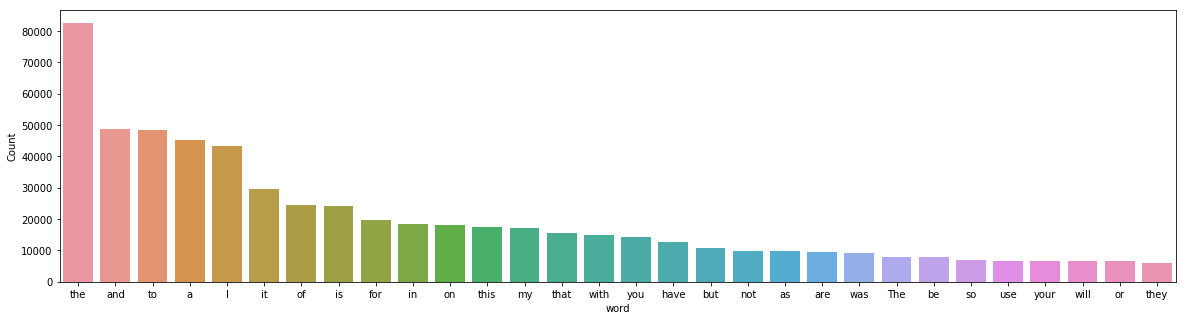

In [13]:
freqwords(df['reviewText'])

In [16]:
# remove unwanted characters, number and symbols
df['reviewText'] = df['reviewText'].str.replace("^a-zA-Z#", "")

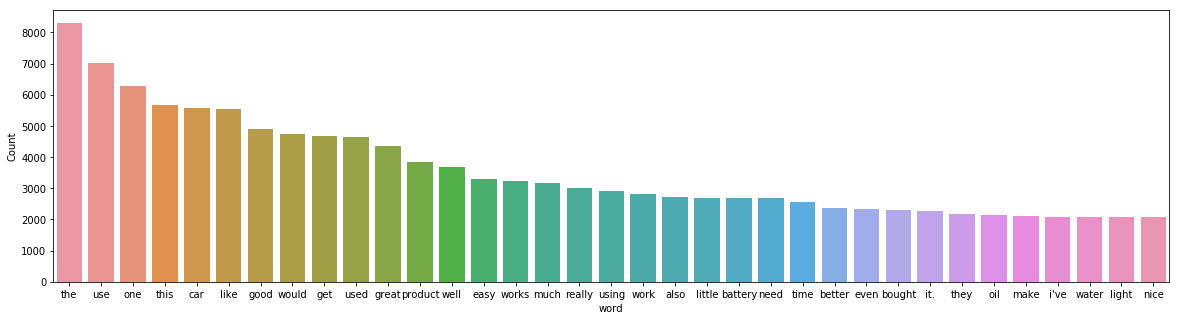

In [35]:
# stop words removing
from nltk.corpus import stopwords
stop_words = stopwords.words('english')

def remove_stopwords(rev):
    rev_new = " ".join([i for i in rev if i not in stop_words])
    return rev_new

# remove shord words(len<3)

df['reviewText'] = df['reviewText'].apply(lambda x: " ".join([w for w in x.split() if len(w)>2]))
    

# remove stopwords from the text
reviews = [remove_stopwords(r.split()) for r in df['reviewText']]


# make entire text lowercase
reviews = [r.lower() for r in reviews]

freqwords(reviews,35)

We can see some improvement here. Terms like ‘battery’, ‘price’, ‘product’, ‘oil’ have come up which are quite relevant for the Automotive category. However, we still have neutral terms like ‘the’, ‘this’, ‘much’, ‘they’ which are not that relevant.

To further remove noise from the text we can use lemmatization from the spaCy library. It reduces any given word to its base form thereby reducing multiple forms of a word to a single word.

In [45]:
nlp = spacy.load('en', disable=['parser', 'ner'])

def lemmatization(texts, tags=['NOUN', 'ADJ']):  #filter noun and adjective
    
    output = []
    for sent in texts:
        doc = nlp(" ".join(sent))
        output.append([token.lemma_ for token in doc if token.pos_ in tags])
        
    return output

In [46]:
tokenized_reviews = pd.Series(reviews).apply(lambda x: x.split())
print(tokenized_reviews[1])

['these', 'long', 'cables', 'work', 'fine', 'truck,', 'quality', 'seems', 'little', 'shabby', 'side.', 'for', 'money', 'expecting', '200', 'dollar', 'snap-on', 'jumper', 'cables', 'seem', 'like', 'would', 'see', 'chinese', 'knock', 'shop', 'like', 'harbor', 'freight', 'bucks.']


In [48]:
reviews_2 = lemmatization(tokenized_reviews)
print(reviews_2)

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



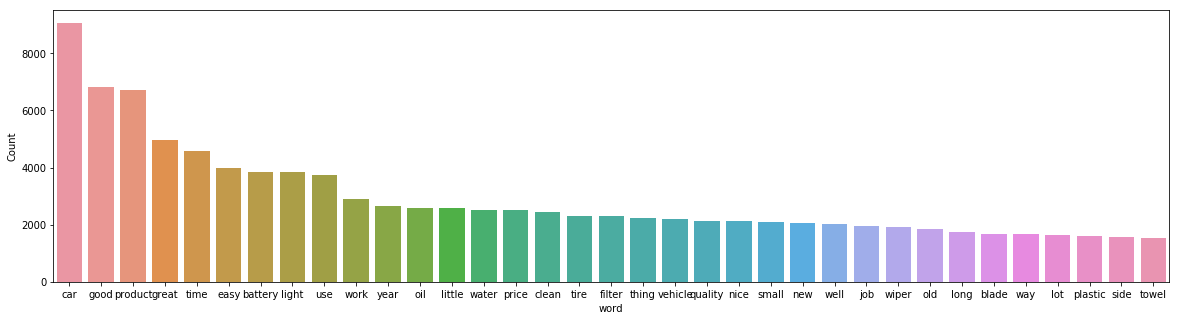

In [50]:
reviews_3 = []
for i in range(len(reviews_2)):
    reviews_3.append(' '.join(reviews_2[i]))

df['reviews'] = reviews_3

freqwords(df['reviews'], 35)

## Building an LDA model

In [51]:
dictionary  = corpora.Dictionary(reviews_2)

In [52]:
# Convert the list of reviews into a doceument term matrix using the dictionary
doc_term_matrix = [dictionary.doc2bow(rev) for rev in reviews_2]

In [53]:
# Creating the object for LDA model using gensim library
LDA = gensim.models.ldamodel.LdaModel

# Build LDA model
lda_model = LDA(corpus=doc_term_matrix, id2word=dictionary, num_topics=7, random_state=100,
                chunksize=1000, passes=50)

In [54]:
lda_model.print_topics()

[(0,
  '0.060*"battery" + 0.030*"power" + 0.028*"car" + 0.024*"unit" + 0.023*"device" + 0.016*"charger" + 0.015*"phone" + 0.013*"charge" + 0.012*"cable" + 0.011*"light"'),
 (1,
  '0.082*"light" + 0.029*"bulb" + 0.022*"bright" + 0.014*"gauge" + 0.011*"tape" + 0.011*"mat" + 0.010*"color" + 0.010*"white" + 0.009*"pressure" + 0.009*"headlight"'),
 (2,
  '0.024*"car" + 0.021*"oil" + 0.015*"filter" + 0.014*"engine" + 0.013*"good" + 0.012*"product" + 0.011*"price" + 0.010*"time" + 0.010*"vehicle" + 0.009*"change"'),
 (3,
  '0.074*"wiper" + 0.069*"blade" + 0.027*"windshield" + 0.026*"rain" + 0.018*"snow" + 0.015*"year" + 0.014*"window" + 0.012*"old" + 0.011*"ice" + 0.010*"side"'),
 (4,
  '0.043*"car" + 0.034*"product" + 0.019*"good" + 0.018*"towel" + 0.017*"clean" + 0.015*"water" + 0.013*"great" + 0.012*"time" + 0.012*"leather" + 0.010*"use"'),
 (5,
  '0.059*"tire" + 0.025*"trailer" + 0.025*"wheel" + 0.021*"door" + 0.016*"seat" + 0.013*"brake" + 0.013*"cover" + 0.012*"board" + 0.009*"hitch" + 

## Topic visualization

In [55]:
# Visualize the topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, doc_term_matrix, dictionary)
vis

/home/aims/.local/lib/python3.7/site-packages/pyLDAvis/_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
4      0.141666 -0.065330       1        1  25.388762
6      0.106418 -0.101099       2        1  25.094452
2      0.104913 -0.047285       3        1  16.967255
0      0.043836 -0.087425       4        1  10.408150
1      0.046285  0.068915       5        1   9.615421
5     -0.406857 -0.091845       6        1   6.961786
3     -0.036260  0.324069       7        1   5.564175, topic_info=    Category         Freq     Term        Total  loglift  logprob
136  Default  4402.000000    light  4402.000000  30.0000  30.0000
34   Default  3045.000000  battery  3045.000000  29.0000  29.0000
860  Default  1999.000000    wiper  1999.000000  28.0000  28.0000
888  Default  1853.000000    blade  1853.000000  27.0000  27.0000
311  Default  1992.000000     tire  1992.000000  26.0000  26.0000
..       ...          ...      ...          ...      ...      ...
16    Topic7   184.905792     time  4406.487793  -0.2822  -4.9833
476   Topic7   159.246765     well  1883.903809   0.4182  -5.1327
12    Topic7   153.632553      new  1853.649780   0.3985  -5.1686
0     Topic7   137.993225    brand   808.823608   1.1204  -5.2759
7     Topic7   141.959167     good  6203.640137  -0.8885  -5.2476

[411 rows x 6 columns], token_table=      Topic      Freq       Term
term                            
3188      4  0.994794        12v
1482      4  0.995106  accessory
1070      4  0.208876   accurate
1070      5  0.789085   accurate
2614      2  0.404569    adapter
...     ...       ...        ...
252       4  0.099482       year
252       5  0.055818       year
252       7  0.183208       year
1435      1  0.242115     yellow
1435      5  0.758626     yellow

[638 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[5, 7, 3, 1, 2, 6, 4])